In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
                       PointPixelElectrode, PotentialObjective,
                       PatternRangeConstraint, shaped)
import sion as sn




Potential minimum: (6.08e-15, 70, 137) mkm
Secular frequencies: (1.226, 2.463, 3.663) MHz
In directions  [[ 1.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -9.99999889e-01  4.70244146e-04]
 [ 0.00000000e+00 -4.70244146e-04 -9.99999889e-01]]
Anisotropy parameter: 0.248


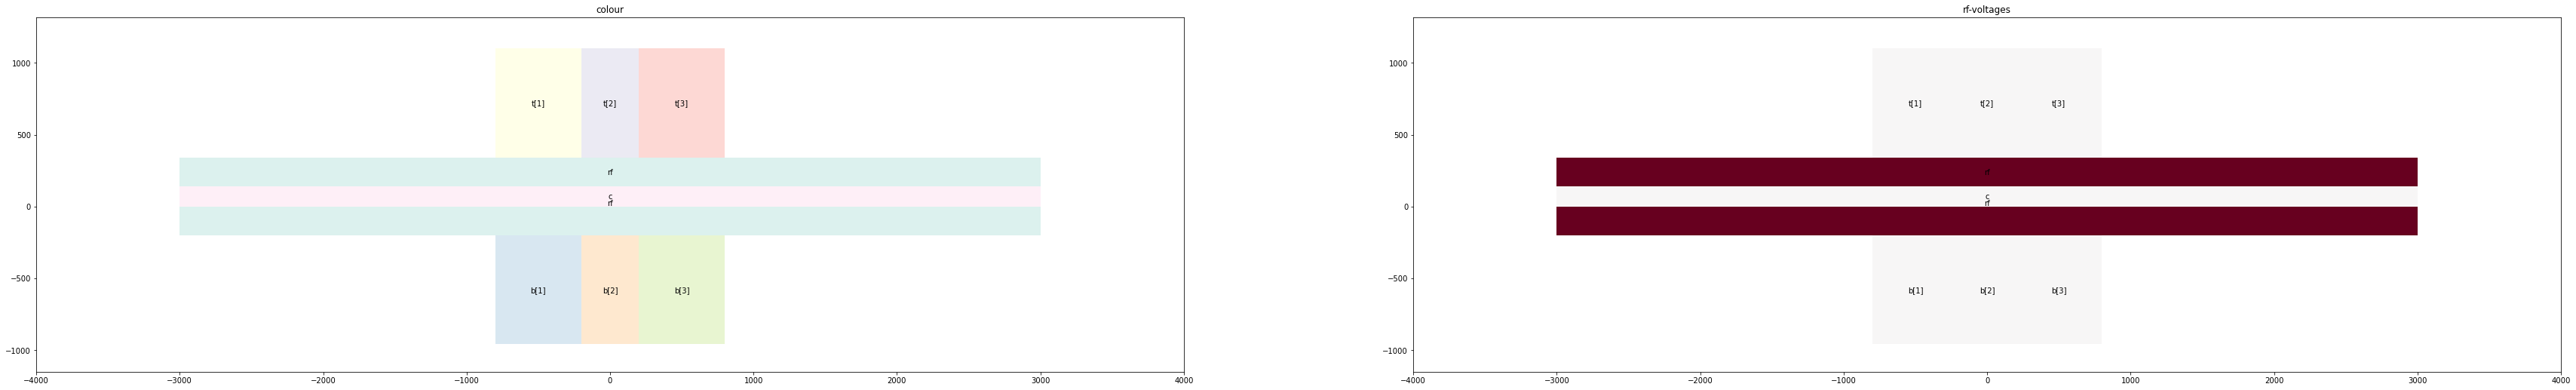

In [49]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 199.3 # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*43e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 140  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 200  # width of top rf electrode, not including width of central electrode
rflength = 6000  # length of rf electrodes
rfbottom = 200  # width of bottom rf electrode
patternTop = 1  # number of groups of Top dc electrodes, defined in DCtop. if None then = 1
patternBot = 1  # same for bottom dcs
getCoordinate = None  # If not None, writes a file with coordinates of vertexes of electrodes
gapped = 0  # gaps between central DC electrode and RF lines
cheight = 1000  # height of the grounded cover electrode plane
cmax = 0  # order of the expansion of cover potential. if 0 - coder not considered, if 5 - considered with optimal precision
plot = 1

elec, Numb, sist = sn.FiveWireTrap(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, patternTop, patternBot, getCoordinate, gapped, cheight, cmax, plot)

x0 = L*np.array(sist.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
u_set = np.array([0, 15, -15, 15, 15, -15, 15, 1.40251])
# routine to find secular frequencies in minimum point
with sist.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x = sist.minimum((0., 90, 120), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('Potential minimum: (%.3g, %.3g, %.3g) mkm' % (x[0], x[1], x[2]))

    # Get trap frequencies
    try:
        curv_z, mod_dir = sist.modes(x, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions ", mod_dir)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6

## Equilibrium ion positions

Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final positions of ions in mkm:
 [[ -9.35  70.   137.01]
 [ -5.57  67.92 137.05]
 [ -5.57  72.08 137.05]
 [ -1.8   72.12 137.06]
 [ -1.8   67.88 137.06]
 [  1.8   67.88 137.06]
 [  1.8   72.12 137.06]
 [  5.57  67.92 137.05]
 [  5.57  72.08 137.05]
 [  9.35  70.   137.01]]


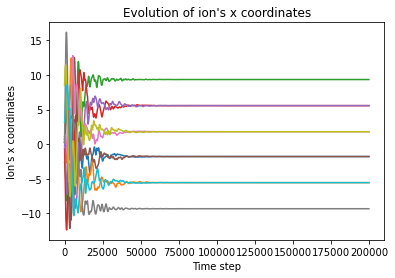

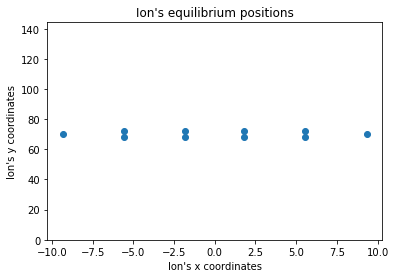

In [51]:

ion_number = 10
x0 = x*1e-6

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x0, ion_number, 10e-6)
s.append(pl.placeions(ions, positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#temperature initialization
s.append(pl.thermalvelocities(5, False))

#cooling simulation
s.append(pl.langevinbath(0, 1e-6))

#files with simulation information
s.append(pl.dump('2Dpositions_eq.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(2e5))
s.execute()

_, data = pl.readdump('2Dpositions_eq.txt')
data *= 1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

np.set_printoptions(2)
print('Final positions of ions in mkm:\n', ion_positions)


plt.figure()
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([60, 80])
plt.show()


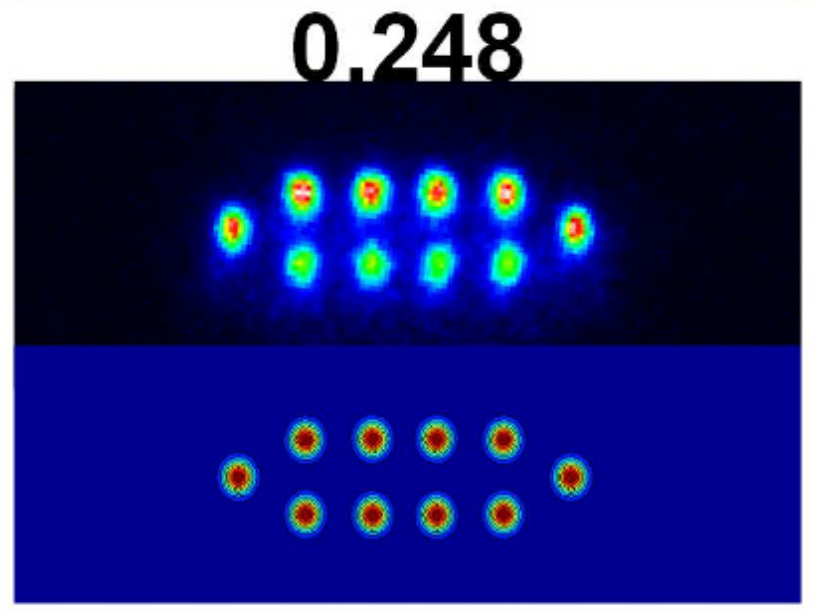

## Ion crystal normal modes

For this 2D crystal we calculate normal mode vectors and their frequencies. The normal mode spectrum is consensual with qualitative analysis. Z-axis modes are mostly uncoupled to the rest modes, because the crystal has almost 0 distribution along z-axis. Additionally, edge ions are less coupled to the main bulk of central 8 ions. 

Normal mode frequencies: [ 638253.98  937638.96 1226192.83 1387780.79 1626044.33 1860093.89
 1886032.32 2029951.94 2053700.13 2268080.58 2273136.7  2364367.37
 2388166.63 2462682.31 2464168.01 2532361.95 2716649.51 2759647.52
 2921031.39 2926435.95 3001772.51 3043823.87 3221772.1  3259547.25
 3319460.49 3440237.47 3459545.84 3528396.48 3663317.67 3866271.57]


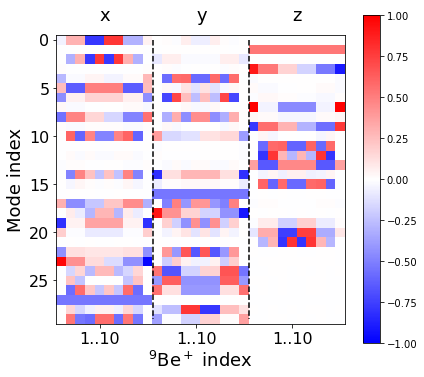

In [76]:
ion_masses = [mass for el in range(ion_number)]
omegas = [omega_sec for el in range(ion_number)]
ion_positions = np.array([[ -9.35,  70. ,  137.01],
 [ -5.57,  67.92, 137.05],
 [ -5.57,  72.08, 137.05],
 [ -1.8 ,  72.12, 137.06],
 [ -1.8 ,  67.88, 137.06],
 [  1.8 ,  67.88, 137.06],
 [  1.8 ,  72.12, 137.06],
 [  5.57,  67.92, 137.05],
 [  5.57,  72.08, 137.05],
 [  9.35,  70.  , 137.01]])*L

#obtaining normal modes, for general case
freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses)
print("Normal mode frequencies:", freqs)

plt.figure(figsize = [6, 6])
plt.imshow(modes[::-1,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar(shrink = 0.8)
plt.tight_layout()
plt.vlines([9.5,19.5], ymin = 0, ymax = 29 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(4, -2,'x', fontsize = 18)
plt.text(14,-2,'y',fontsize = 18)
plt.text(24, -2,'z',fontsize = 18)
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 18)
plt.ylabel('Mode index', fontsize = 18)
plt.xticks([4, 14, 24],['1..10', '1..10', '1..10'],fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.show()

# Crystal frequencies from Fourier analysis

In [53]:
ion_positions = np.array([[ -9.35,  70. ,  137.01],
 [ -5.57,  67.92, 137.05],
 [ -5.57,  72.08, 137.05],
 [ -1.8 ,  72.12, 137.06],
 [ -1.8 ,  67.88, 137.06],
 [  1.8 ,  67.88, 137.06],
 [  1.8 ,  72.12, 137.06],
 [  5.57,  67.92, 137.05],
 [  5.57,  72.08, 137.05],
 [  9.35,  70.  , 137.01]])

start_positions = []
for pos in ion_positions:
    start_positions.append(L*(pos + np.random.rand(3)-np.array([0.5,0.5,0.5]) ))

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
s.append(pl.placeions(ions, start_positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#files with simulation information
s.append(pl.dump('2Dpositions.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(1e5))
s.execute()

_, data = pl.readdump('2Dpositions.txt')
data *= 1e6


Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


1.85082393704889e-06
5402.999064268017


C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\matplo

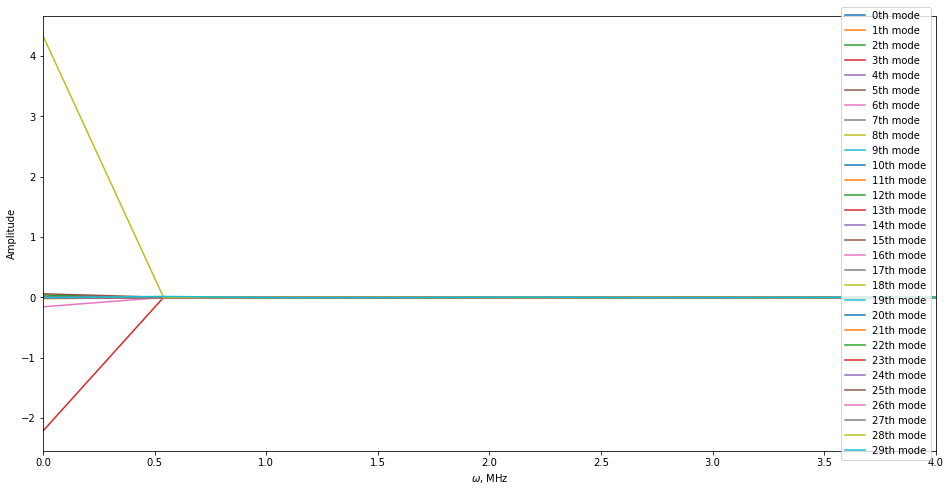

In [82]:
_, data = pl.readdump('2Dpositions.txt')
x = data[:, :, 0]
y = data[:, :, 1]
z = data[:, :, 2]

T = data.shape[0]/(20*Omega) # simulation time
print(T)
freqsfft = np.arange(data.shape[0])/T/1e6
print(freqsfft[-1])

normal_coordinates = []
for mode in modes:
    coord = np.zeros(data.shape[0])
    for i in range(ion_number):
        for j in range(3):
            coord = coord + mode[i + ion_number*j]*data[:, i, j]
    normal_coordinates.append(coord)
normal_spectrum = []
for norm_coord in normal_coordinates:
    ion_spectrum = np.fft.fft(norm_coord)
    normal_spectrum.append(ion_spectrum)
    
plt.figure(figsize = (16,8))
for n, ion_spectrum in enumerate(normal_spectrum):
    plt.plot(freqsfft, ion_spectrum, label = str(n)+'th mode')
plt.legend(loc = 'right')
plt.xlabel('$\omega$, MHz')
plt.xlim(0, 4)
plt.ylabel('Amplitude')
plt.show()

In [83]:
fft_frequencies = []
for ion_spectrum in normal_spectrum:
    fft_frequecnies.append(freqsfft[np.argmax(np.abs(ion_spectrum))])
    
print('Difference in normal frequencies:\n', freqs - fft_frequencies*1e6)

0.5402999064268017
0.0
5391.112466326627
1.0805998128536034
0.0
0.5402999064268017
0.0
0.0
18.37019681851126
21.071696350645265
0.0
0.0
0.0
0.0
22.15229616349887
1.0805998128536034
5376.524368853104
24.313495789206076
25.93439550848648
0.0
29.716494853474096
5402.999064268017
32.417994385608104
0.0
0.0
0.0
34.57919401131531
0.0
0.0
0.5402999064268017
